In [54]:
# modules - probably too many
import numpy as np
import pandas as pd
import pickle
import matplotlib
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'
# import scann
import math
import seaborn as sns
# import geopandas as gpd
import multiprocessing
import numpy.matlib as npm
import geeadd
import ee
import geemap
import mlLocal
from geemap import ml
from importlib import reload

In [4]:
ee.Authenticate()

Enter verification code:  4/1AfgeXvtxYjV9n5XKK682Xb5t3U1xrnvFzGEots7nhTCSj596BI43CVid_vQ



Successfully saved authorization token.


In [5]:
ee.Initialize()

In [72]:
# parse a sckitlearn decision tree into a R text tree suitable for use in GEE
# for compactness ancillary items like node sample size and residuals are forced to = 1
# this is a blind guess by Richard but seems to work
def make_tree(rf,regressors,decimals):
    
    # first get the output in sckitlearn text format in a dataframe
    r = export_text(rf,feature_names=regressors,show_weights=True,decimals=decimals)
    r = r.splitlines()
    rdf = pd.DataFrame(r,columns = ['rule'])

    #identify rules and not leaf values
    isrule = ~rdf['rule'].str.contains('value')
    rulesdf = rdf.loc[isrule]

    #determine level in tree and the associated starting based node number
    rdf['level'] = rdf['rule'].str.count(r'(\|)').values.tolist()
    rdf.loc[isrule,'base'] = ((rdf.level).mul(0).add(2)).pow(rdf.level)

    # get the actual tested condition
    rdf.loc[isrule,'condition'] =  rdf.loc[isrule,'rule'].str.extract(r'(x.+)').values.tolist()
    


    # convert intos to floats
    
    # identify leaf nodes and fill in the response value
    rdf.loc[~isrule,'leaf'] = '*'
    rdf['leaf'] = rdf['leaf'].fillna(method='bfill',limit=1)
    rdf.loc[~isrule,'response'] = rdf.loc[~isrule,'rule'].str.extract(r'([+-]?([0-9]*[.])?[0-9]+)')[0].values.tolist()
    rdf['response'] = rdf['response'].fillna(method='bfill')

    #discard non rules
    rdf.loc[rdf['leaf'].isna(),'leaf'] = ' '
    rdf = rdf.dropna()

    #dtermine if this is a left or right branch
    rdf['branch'] = rdf['rule'].str.contains(r'(?:\>)').astype('int')
    rdf['node'] = rdf.base + rdf.branch
    rdf.loc[rdf.level==1,'node']=rdf.loc[rdf.level==1,'branch'] + 2
    rdfindex = rdf.index

    #asign a node number, this is non trivial and critical for use later
    #read https://www.r-bloggers.com/2022/10/understanding-leaf-node-numbers-when-using-rpart-and-rpart-rules/
    for row in range(2,rdf.shape[0]):
        # find the nearest row above
        df = rdf[0:row]
        if ( (rdf[row:row+1].level.values)[0] > 1 ):
            parentdf = df.loc[df.level == (rdf[row:row+1].level.values-1)[0]].iloc[-1]
            rdf.at[rdfindex[row],'parentbase'] = parentdf.base  
            rdf.at[rdfindex[row],'parentnode'] = parentdf.node  
            rdf.at[rdfindex[row],'node'] = rdf.iloc[row].node + 2 * (  parentdf.node - parentdf.base ) 
            
    # glue together each rule in a big string, add the root node and return as a list
    rdf['phrase'] = rdf.apply(lambda x:  ' ' *(2 * x.level) + str(int(x.node)) + ') ' + x.condition + ' 0 0 ' + str(x.response) + ' ' +x.leaf + '\n', axis=1)
    return ( '1) root 1 1 1 (1)\n'+''.join(rdf['phrase'].values.tolist()))

In [8]:
#create a linear hash table to code the input feature domain
def makeDomain(df,domainIndex,domainScaling,domainOffset):
    df = np.array(df) 
    domainIndex = np.array(domainIndex)
    domainScaling = np.array(domainScaling)
    domainOffset = np.array(domainOffset)
    
    return np.uint64(np.unique(np.sum((np.around(df* domainScaling,0 ) ) * np.power(10,np.cumsum(domainIndex)-domainIndex[0]),1),0)).tolist()
          

In [9]:
# checks if an observation is in domain
def checkDomain(df,domainIndex,domainScaling,domainOffset,domain):
    df = np.array(df) 
    domainIndex = np.array(domainIndex)
    domainScaling = np.array(domainScaling)
    domainOffset = np.array(domainOffset)
    domainCode = np.sum((np.around(df* domainScaling,0 ) ) * np.power(10,np.cumsum(domainIndex)-domainIndex[0]),1)
    domainFlag = []
    for code in domainCode:
        if code in domain :
            domainFlag.append(1)
        else:
            domainFlag.append(0)
    return domainFlag

In [15]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed bin widths
def trimDF(df,x,y,percentiles,bins,binwidth):
    df = df.sort_values(by=x).reset_index()
    for i in range (len(bins)-1):
        data = df.loc[abs(df[x]-bins[i])<binwidth[i]]
        if not data.empty:
            df = df.drop(data.loc[(data[y]<np.percentile(data[y], percentiles[0]))].index.values)
            df = df.drop(data.loc[(data[y]>np.percentile(data[y], percentiles[1]))].index.values)
    return df



In [16]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed sample sizesd
def trimDFNumSample(df,x,y,percentiles,numsamples):
    # sort DF by the x value to speed up subsetting
    dropList = []
    df = df.sort_values(by=x)
    N = df.shape[0]
    print(N)
    for i in range(0,N,numsamples):
        # find location of value nearest to current bi
        Sample = df[i:np.minimum(i+numsamples,N)]
        dropList.append(Sample.loc[(Sample[y]<=np.percentile(Sample[y],percentiles[0])) | (Sample[y]>=np.percentile(Sample[y],percentiles[1]))].index.tolist()) 
    print(len(sum(dropList,[])))
    return df.drop(sum(dropList,[]))

In [17]:
# scales all coumndsin DF to be betweeen 0 and 1
def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(dfTest[col])),columns=[col])
    return df

In [18]:
#applies a histogram on a portion of a data frame
def reduce_func(D_chunk, start):
    return np.histogram(D_chunk)

In [20]:
# parse samples from Landsat7MOD15A python notebook
# this is quite specific to richard landsat mapping algorithm
def parseSamples(directoryPath,fileSuffix):

    file_name = ['LUTinputLC0XB36', 'LUTinputLC0XB45','LUTinputMOD09' ,'LUTinputLC0XLat', \
                 'LUTinputLC0XLon','LUToutputLC0X','YearLC0X','MonthLC0X', \
                 'DayLC0X','PathLC0X','RowLC0X','FparLai_QC','FparExtra_QC']

    dataset = []
    DataList = []
    count = 0

    for name in file_name:
        dataset.append(f'{directoryPath}{name}{fileSuffix}')

    for name_dataset in dataset:
        with open(f'{name_dataset}', 'rb') as fp1:
            objs = []
            while 1:
                try:
                    objs.append(pickle.load(fp1))
                except EOFError:
                    break
            DataList = [item for sublist in objs for item in sublist]

        if count == 0:
            LUTB36_list = DataList
        elif count == 1:
            LUTB45_list = DataList
        elif count == 2:
            LUTMOD09_list = DataList
        elif count == 3:
            LUTLat = DataList
        elif count == 4:
            LUTLon = DataList
        elif count == 5:
            LUToutput_list = DataList
        elif count == 6:
            LUTyear = DataList
        elif count == 7:
            LUTmonth = DataList
        elif count == 8:
            LUTday = DataList
        elif count == 9:
            LUTpath = DataList
        elif count == 10:
            LUTrow = DataList
        elif count == 11:
            LUTQC= DataList
        elif count == 12:
            LUTQCextra = DataList
        count = count + 1
        
        
    # make sure all arrays are same length   
    LUTB36_list = LUTB36_list[0:(len(LUTQC))]
    LUTB45_list = LUTB45_list[0:(len(LUTQC))]
    LUTMOD09_list = LUTMOD09_list[0:(len(LUTQC))]
    LUTLat = LUTLat[0:(len(LUTQC))]
    LUTLon = LUTLon[0:(len(LUTQC))]
    LUToutput_list = LUToutput_list[0:(len(LUTQC))]
    LUTyear = LUTyear[0:(len(LUTQC))]
    LUTmonth = LUTmonth[0:(len(LUTQC))]
    LUTday = LUTday[0:(len(LUTQC))]
    LUTpath = LUTpath[0:(len(LUTQC))]
    LUTrow = LUTrow[0:(len(LUTQC))]
    LUTQC = LUTQC[0:(len(LUTQC))]    
    LUTQCextra = LUTQCextra[0:(len(LUTQC))]


    # parse the LUTs into Pandas tables
    LUT_Lai = np.double(np.floor(np.mod(LUToutput_list,1e2)/1e0))
    LUT_LaiStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e4)/1e2)))
    LUT_Fpar = np.double(np.floor(np.mod(LUToutput_list,1e6))/1e4)
    LUT_FparStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e8)/1e6)))
    # LUT_satFlag = np.uint64(np.floor(np.mod(LUToutput_list,1e11))/1e9)
    # LUT_snowFlag = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e14)/1e12)))
    LUT_LC_Type3 = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e16)/1e14)))
    LUT_satFlag = (np.array(LUTQC)== 32).astype(int)
    LUT_snowFlag =  (((np.array(LUTQCextra)== 4).astype(int)+(np.array(LUTQCextra)== 132).astype(int))>0).astype(int)


    LUT_SR_B3 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e3)/1)))
    LUT_SR_B4 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e3)/1)))

    LUT_SR_B5 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e6)/1e3)))
    LUT_SR_B6 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e6)/1e3)))
    LUT_VIEW_ZENITH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e8)/1e6)))
    LUT_VIEW_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e11)/1e8)))
    LUT_SUN_ELEVATION = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e13)/1e11)))
    LUT_SUN_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e16)/1e13)))

    LUT_MOD09_red = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e4)/1)))
    LUT_MOD09_NIR = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e8)/1e4)))
    LUT_MSUN_ZENITH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e10)/1e8)))
    LUT_MSUN_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e13)/1e10)))
    LUT_MVIEW_ZENITH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e15)/1e13)))
    LUT_MVIEW_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e18)/1e15)))
 
    # make pandas frame of all coded inputs
    return pd.DataFrame( {'year':LUTyear, 'month': LUTmonth, 'day': LUTday, 'path':LUTpath, 'row':LUTrow,\
                          'Lat':LUTLat, 'Lon':LUTLon, 'input36': LUTB36_list,'input45':LUTB45_list, 'inputMOD09': LUTMOD09_list, 'redMODIS': LUT_MOD09_red,'NIRMODIS': LUT_MOD09_NIR,\
                          'green':LUT_SR_B3 * 10, 'red':LUT_SR_B4 * 10, 'NIR': LUT_SR_B5 * 10, 'SWIR1': LUT_SR_B6 * 10,   \
                          'SensorZenith':LUT_VIEW_ZENITH, 'SensorAzimuth': LUT_VIEW_AZIMUTH, 'SolarZenith':LUT_SUN_ELEVATION, 'SolarAzimuth': LUT_SUN_AZIMUTH, \
                          'M_sensor_zenith':LUT_MVIEW_ZENITH, 'M_sensor_azimuth': LUT_MVIEW_AZIMUTH, 'M_sun_zenith':LUT_MSUN_ZENITH, 'M_sun_azimuth': LUT_MSUN_AZIMUTH, \
                          'LC_type3': LUT_LC_Type3, 'output': LUToutput_list,'LAI': LUT_Lai, 'stdLAI': LUT_LaiStdDev, 'FAPAR': LUT_Fpar, 'stdFAPAR': LUT_FparStdDev,\
                          'LUT_satFlag': LUT_satFlag,'LUT_snowFlag': LUT_snowFlag,'LC_type3': LUT_LC_Type3}) \
               .sort_values('input36')

In [21]:
# parses samples from Landsat7MOD15NA notebook assuming no QC and snow LUTs are present
# this is quite specific to richard landsat mapping algorithm
def parseSamples2(directoryPath,fileSuffix):

    file_name = ['LUTinputLC0XB36', 'LUTinputLC0XB45','LUTinputMOD09' ,'LUTinputLC0XLat', \
                 'LUTinputLC0XLon','LUToutputLC0X','YearLC0X','MonthLC0X', \
                 'DayLC0X','PathLC0X','RowLC0X']

    dataset = []
    DataList = []
    count = 0

    for name in file_name:
        dataset.append(f'{directoryPath}{name}{fileSuffix}')

    for name_dataset in dataset:
        with open(f'{name_dataset}', 'rb') as fp1:
            objs = []
            while 1:
                try:
                    objs.append(pickle.load(fp1))
                except EOFError:
                    break
            DataList = [item for sublist in objs for item in sublist]

        if count == 0:
            LUTB36_list = DataList
        elif count == 1:
            LUTB45_list = DataList
        elif count == 2:
            LUTMOD09_list = DataList
        elif count == 3:
            LUTLat = DataList
        elif count == 4:
            LUTLon = DataList
        elif count == 5:
            LUToutput_list = DataList
        elif count == 6:
            LUTyear = DataList
        elif count == 7:
            LUTmonth = DataList
        elif count == 8:
            LUTday = DataList
        elif count == 9:
            LUTpath = DataList
        elif count == 10:
            LUTrow = DataList

        count = count + 1


    # parse the LUTs into Pandas tables
    LUT_Lai = np.double(np.floor(np.mod(LUToutput_list,1e2)/1e0))
    LUT_LaiStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e4)/1e2)))
    LUT_Fpar = np.double(np.floor(np.mod(LUToutput_list,1e6))/1e4)
    LUT_FparStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e8)/1e6)))
    LUT_satFlag = np.uint64(np.floor(np.mod(LUToutput_list,1e11))/1e8)
    LUT_snowFlag = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e14)/1e11)))
    LUT_LC_Type3 = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e16)/1e14)))



    LUT_SR_B3 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e3)/1)))
    LUT_SR_B4 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e3)/1)))

    LUT_SR_B5 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e6)/1e3)))
    LUT_SR_B6 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e6)/1e3)))
    LUT_VIEW_ZENITH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e8)/1e6)))
    LUT_VIEW_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e11)/1e8)))
    LUT_SUN_ELEVATION = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e13)/1e11)))
    LUT_SUN_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e16)/1e13)))

    LUT_MOD09_red = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e4)/1)))
    LUT_MOD09_NIR = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e8)/1e4)))
    LUT_MSUN_ZENITH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e10)/1e8)))
    LUT_MSUN_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e13)/1e10)))
    LUT_MVIEW_ZENITH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e15)/1e13)))
    LUT_MVIEW_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e18)/1e15)))
    
    # make pandas frame of all coded inputs
    return pd.DataFrame( {'year':LUTyear, 'month': LUTmonth, 'day': LUTday, 'path':LUTpath, 'row':LUTrow,\
                          'Lat':LUTLat, 'Lon':LUTLon, 'input36': LUTB36_list,'input45':LUTB45_list, 'inputMOD09': LUTMOD09_list, 'redMODIS': LUT_MOD09_red,'NIRMODIS': LUT_MOD09_NIR,\
                          'green':LUT_SR_B3 * 10, 'red':LUT_SR_B4 * 10, 'NIR': LUT_SR_B5 * 10, 'SWIR1': LUT_SR_B6 * 10,   \
                          'SensorZenith':LUT_VIEW_ZENITH, 'SensorAzimuth': LUT_VIEW_AZIMUTH, 'SolarZenith':LUT_SUN_ELEVATION, 'SolarAzimuth': LUT_SUN_AZIMUTH, \
                          'M_sensor_zenith':LUT_MVIEW_ZENITH, 'M_sensor_azimuth': LUT_MVIEW_AZIMUTH, 'M_sun_zenith':LUT_MSUN_ZENITH, 'M_sun_azimuth': LUT_MSUN_AZIMUTH, \
                          'LC_type3': LUT_LC_Type3, 'output': LUToutput_list,'LAI': LUT_Lai, 'stdLAI': LUT_LaiStdDev, 'FAPAR': LUT_Fpar, 'stdFAPAR': LUT_FparStdDev,\
                          'LUT_satFlag': LUT_satFlag,'LUT_snowFlag': LUT_snowFlag,'LC_type3': LUT_LC_Type3}) \
               .sort_values('input36')

In [29]:
# read in all sampled data and parse
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/calibrationVersion5/NorthAmerica/'
fileSuffix = 'calv7'
dfALL = parseSamples(directoryPath ,fileSuffix)
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/calibrationVersion5/NorthernEuropeAsia/'
fileSuffix = 'calv8'
df = parseSamples(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/calibrationVersion5/SouthernHemisphere/'
fileSuffix = 'calv5'
df = parseSamples(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/validationVersion5/Global/'
fileSuffix = 'calv13'
df = parseSamples(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/validationVersion5/NorthAmerica/'
fileSuffix = 'calv9'
df = parseSamples(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/validationVersion5/NorthEuropeAsia/'
fileSuffix = 'calv10'
df = parseSamples(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/validationVersion5/Global/'
fileSuffix = 'calv13'
df = parseSamples(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/calibrationVersion7/'
fileSuffix = 'calv13'
df = parseSamples(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/calibrationVersion6/NorthAmerica/'
fileSuffix = 'calv20'
df = parseSamples(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/calibrationVersion4/'
fileSuffix = 'calv4'
df = parseSamples2(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])
directoryPath  = 'C:/Users/rfernand/Downloads/modislandsat/calibrationVersion3/'
fileSuffix = 'calv3'
df = parseSamples(directoryPath ,fileSuffix)
dfALL = pd.concat([dfALL,df])





LUTB36_list: 6792058
LUTB45_list: 6792058
LUTMOD09_list: 6792058
LUTLat: 6792058
LUTLon: 6792058
LUToutput_list: 6792058
LUTyear: 6792058
LUTmonth: 6792058
LUTday: 6792058
LUTpath: 6792058
LUTrow: 6792058
LUTQC: 6792058
LUTQCextra: 6792058
LUTB36_list: 13379726
LUTB45_list: 13379726
LUTMOD09_list: 13379726
LUTLat: 13379726
LUTLon: 13379726
LUToutput_list: 13379726
LUTyear: 13379726
LUTmonth: 13379726
LUTday: 13379726
LUTpath: 13379726
LUTrow: 13379726
LUTQC: 13379726
LUTQCextra: 13379726
LUTB36_list: 7254711
LUTB45_list: 7254711
LUTMOD09_list: 7254711
LUTLat: 7254711
LUTLon: 7254711
LUToutput_list: 7254711
LUTyear: 7254711
LUTmonth: 7254711
LUTday: 7254711
LUTpath: 7254711
LUTrow: 7254711
LUTQC: 7254711
LUTQCextra: 7254711
LUTB36_list: 10220611
LUTB45_list: 10220611
LUTMOD09_list: 10220611
LUTLat: 10220611
LUTLon: 10220611
LUToutput_list: 10220611
LUTyear: 10220611
LUTmonth: 10220611
LUTday: 10220611
LUTpath: 10220611
LUTrow: 10220611
LUTQC: 10220611
LUTQCextra: 10220611
LUTB36_list: 7

In [30]:
# drop duplicates and attach unique index
dfALL = dfALL.drop_duplicates()
dfALL.index = pd.RangeIndex(len(dfALL.index))

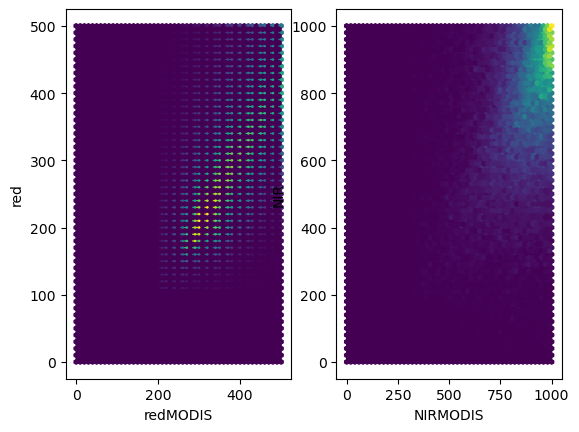

In [31]:
# basic trimming to remove mismatched data 
dfALL2 = dfALL[(dfALL.NIRMODIS >= 200 ) & (dfALL.redMODIS>=200 ) & (dfALL.green > 0 ) & (dfALL.red >100) & (dfALL.NIR > 0 ) & (dfALL.SWIR1 > 0 )& (dfALL.green < 5000) & (dfALL.red < 5000) &  (dfALL.SWIR1 < 5000)  & (dfALL.M_sensor_zenith<70)]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(dfALL2['redMODIS'],dfALL2['red'], gridsize=(50,50), extent=(0,500,0,500))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(dfALL2['NIRMODIS'],dfALL2['NIR'], gridsize=(50,50), extent=(0,1000,0,1000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')
plt.show()

(6901454, 32)


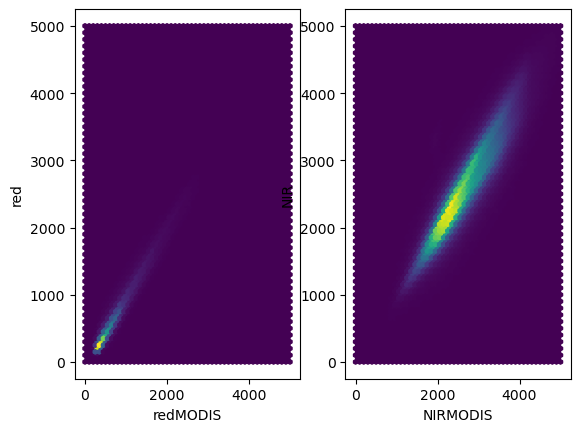

In [32]:
# dataset with MODIS view zenith angle correspoonding to OLI view zenith angle approximately
dfALL3 = dfALL2[dfALL2.M_sensor_zenith<10 ]
print(dfALL3.shape)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hexbin(dfALL3['redMODIS'],dfALL3['red'], gridsize=(50,50), extent=(0,5000,0,5000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(dfALL3['NIRMODIS'],dfALL3['NIR'], gridsize=(50,50), extent=(0,5000,0,5000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')
plt.show()

6901454
748191
6901454
708293
5716203
57314
(5658889, 49)


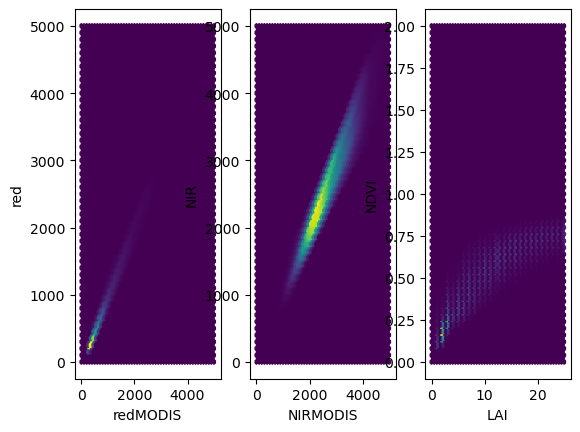

In [36]:
# trimmed dataset for NAIEVE and functional regression and partition into biomes
dfALL4 = trimDFNumSample(dfALL3,'redMODIS','red',[5,95],100000).merge(trimDFNumSample(dfALL3,'NIRMODIS','NIR',[5,95],100000)).drop_duplicates()
dfALL4 = makeFeatures(dfALL4)
dfALL5 = trimDFNumSample(dfALL4,'LAI','NDVI',[0.5,99.5],100000)
print(dfALL5.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.hexbin(dfALL5['redMODIS'],dfALL5['red'], gridsize=(50,50), extent=(0,5000,0,5000))
ax1.set(xlabel='redMODIS', ylabel='red')
ax2.hexbin(dfALL5['NIRMODIS'],dfALL5['NIR'], gridsize=(50,50), extent=(0,5000,0,5000))
ax2.set(xlabel='NIRMODIS', ylabel='NIR')
ax3.hexbin(dfALL5['LAI'],dfALL5['NDVI'], gridsize=(50,50), extent=(0,25,0,2))
ax3.set(xlabel='LAI', ylabel='NDVI')
plt.show()


In [37]:
# subset DF by biome
calbiomeDict = {}
valbiomeDict = {}
for biome in dfALL4['LC_type3'].unique():
    df = dfALL4.loc[dfALL4['LC_type3']==biome]
    valdfBiome = df.sample(frac=0.2)
    caldfBiome = df.drop(valdfBiome.index)
    calbiomeDict.update({biome: {'DF': caldfBiome}})
    valbiomeDict.update({biome: {'DF': valdfBiome}})
    print(biome,caldfBiome.shape,valdfBiome.shape)


6 (412260, 49) (103065, 49)
7 (290970, 49) (72742, 49)
4 (1309919, 49) (327480, 49)
5 (169856, 49) (42464, 49)
2 (372232, 49) (93058, 49)
8 (52017, 49) (13004, 49)
3 (191127, 49) (47782, 49)
1 (1755748, 49) (438937, 49)
9 (17055, 49) (4264, 49)
10 (1778, 49) (445, 49)


In [38]:
# Calibrate the NAIVE algorithm
method = 'NAIVE'

# response variable name
response = ['LAI']

# Regressor Names
# Names within scope of this script
regressorsNames = [ 'red', 'NIR','SolarZenith','SensorZenith','SolarAzimuth','SensorAzimuth']
# Names within scope of GEE
regressorsGEENames =  [ 'SR_B4', 'SR_B5','SZA','VZA','SAA','VAA'] 
# Generic names we export RF with
regressors = ["x1","x2","x3","x4","x5","x6"]

#Specify scaling and index for Domain, currently we only allow one digit per regressor
# Number of digits per regressor
domainIndex = [1,1,1,1,1,1]
# Sxaling per regressor
domainScaling = [ 1/10000, 1/10000,(10/90),(10/90),(10/360),(10/360)]
# Offset per regressor
domainOffset = [ 0,0,0,0,0,0,0,0]


# Calibrate hierarchal randforest preeidctors for each biome
for biome in calbiomeDict.keys():
    print('biome:',biome)
    
    if ( biome <11):
        # subset only the regressors and response and rename them to generic names
        dfBiome = calbiomeDict[biome]['DF'][sum([regressorsNames,response],[])].astype('int')
        dfBiome.columns = sum([regressors,response],[])

        # populate a parent RF dictionary that holds a single tree RF used to partition data into child RFs
        parentRFDict = {}
        parentRFDict.update({'regressors': regressors})
        parentRFDict.update({'regressorsGEE': regressorsGEENames})
        parentRFDict.update({'response': response})
        parentRFDict.update({'domain':makeDomain(dfBiome[regressors],domainIndex,domainScaling,domainOffset)})
        parentRFDict.update({'RF': RandomForestRegressor(n_estimators=1,min_samples_leaf=1000,bootstrap=False,random_state=0,verbose=0,max_depth=10,max_leaf_nodes=1000).fit(dfBiome[regressors], np.array(dfBiome[response]).ravel())})         
        # label input data using the prediction from the parent RF as this will be unique
        dfBiome['estimate']=np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)

        # populate dictionary of children RFs, each childRF is itself a dictionary similar to the parentRF but now using more than one tree
        # each child is labelled using the prediction value from the parentRF corresponding to its partition
        childrenRFDict = {}
        print('number children:',np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)).size)
        for partition in np.unique(np.around(np.array(parentRFDict['RF'].predict(dfBiome[regressors])),decimals=3)):
            dfpartitionBiome = dfBiome.loc[dfBiome['estimate'] == partition]
            childRFDict = {}
            childRFDict.update({'size': dfpartitionBiome[response].shape[0]})
            childRFDict.update({'regressors': regressors})
            childRFDict.update({'regressorsGEE': regressorsGEENames})
            childRFDict.update({'response': response})
            childRFDict.update({'domain':makeDomain(dfpartitionBiome[regressors],domainIndex,domainScaling,domainOffset)})
            childRFDict.update({'RF': RandomForestRegressor(n_estimators=10,min_samples_leaf=50,bootstrap=True,random_state=0,verbose=0,max_depth=9,max_leaf_nodes=1000) \
                                     .fit(dfpartitionBiome[regressors], np.array(dfpartitionBiome[response]).ravel())})             
            childrenRFDict.update({partition: childRFDict})

        # assign the childrenRFDict to the parent
        parentRFDict.update({'childrenRFDict':childrenRFDict })      

        #assign the parentRF dict to the calibration data dictionary for trhis biome
        calbiomeDict[biome].update({method+response[0]+'parentRFDict':parentRFDict})


biome: 6
number children: 252
biome: 7
number children: 212
biome: 4
number children: 590
biome: 5
number children: 114
biome: 2
number children: 229
biome: 8
number children: 40
biome: 3
number children: 143
biome: 1
number children: 647
biome: 9
number children: 13
biome: 10
number children: 1


In [81]:
#  upload classiers to gee as feature collections
reload(mlLocal)

# Calibrate the NAIVE algorithm
method = 'NAIVE'

# response variable name
response = ['LAI']

# Scalnig and offset required of GEE regressors
regressorsGEECollectionName= "LANDSAT/LC08/C02/T1_L2"
regressorsGEEScaling = [2.75e-05,2.75e-05,0.01,0.01,0.01,0.01]
regressorsGEEOffset = [-0.02,-0.02,0,0,180,180]
regressorsGEEScaling2 = [10000,10000,1,1,1,1]


for biome in dfALL4['LC_type3'].unique():
    print(biome)
    if ( biome ==9) :
        parentRFDict = calbiomeDict[biome][method+response[0]+'parentRFDict']
        domain = parentRFDict['domain']
        trees = []
        trees.append(make_tree(parentRFDict['RF'][0],regressors,3))
        # print(trees[0])
        print(len(parentRFDict['childrenRFDict']))
        assetID = geemap.ee_user_id() + '/modisLandsatTrees/' + method + 'biome' + str(biome) + 'parentRF' 
        mlLocal.export_trees_to_fc_CCRS(trees,response,regressors,regressorsGEECollectionName,regressorsGEENames,regressorsGEEScaling2,regressorsGEEScaling,regressorsGEEOffset,domain,domainScaling,domainOffset,assetID)
        #ml.export_trees_to_fc(trees,assetID)
        # ee_classifier = ml.strings_to_classifier(trees)
        # print(ee_classifier.getInfo())

        childSize = []
        for partition in parentRFDict['childrenRFDict'].keys():
            # print(partition)
            childRFDict = parentRFDict['childrenRFDict'][partition]
            childSize.append(childRFDict['size'])

            trees = []
            for tree in [childRFDict['RF'][1]] :
                 trees.append(make_tree(tree,regressors,3))
            # print(trees[0])
            # trees = ml.rf_to_strings(estimator=childRFDict['RF'], feature_names=regressors,processes=36,output_mode='REGRESSION')
            assetID = geemap.ee_user_id() + '/modisLandsatTrees/' + method + 'biome' + str(biome) + 'childRF' + str(int(partition*1000)) 
            domain = [0]
            domainScaling = [0]
            domainOffset = [0]
            mlLocal.export_trees_to_fc_CCRS(trees,response,regressors,regressorsGEECollectionName,regressorsGEENames,regressorsGEEScaling2,regressorsGEEScaling,regressorsGEEOffset,domain,domainScaling,domainOffset,assetID)
            # ml.export_trees_to_fc(trees,assetID)
            # ee_classifier = ml.strings_to_classifier(trees)
            # print(ee_classifier.getInfo())
        print(childSize)

6
7
4
5
2
8
40
[1092, 1287, 1266, 1058, 1842, 1020, 1023, 1000, 1971, 1029, 1046, 1737, 1205, 1064, 1524, 1435, 1011, 1101, 1116, 1662, 1223, 1017, 1013, 1007, 1657, 1204, 1225, 1180, 1627, 1185, 1256, 1046, 1709, 1103, 1123, 1392, 1915, 1160, 1552, 1934]
3
1
9
10
